# Flow modelling – Adding/removing/shifting flows

In [1]:
import graph_tool as gt
import graph_tool.draw
import numpy as np
import datetime
import cairo

In [2]:
print("Date:", datetime.datetime.now().date().isoformat())

Date: 2018-10-09


In [3]:
(datetime.datetime.now().date() + datetime.timedelta(days=100)).isoformat()

'2019-01-17'

## Flow splitting

In [4]:
def split_flows(G):
    """Split the flows based on material composition
    
    If a flow is composed of different materials, it is split into individual flows per material 
    with the corresponding mass.
    If the flow is composed of a single material, the composition property is removed and replaced with material.
    
    Returns
    -------
    graph
        The updated graph
    eprop_material
        Edge property (materials), string
    eprop_mass
        Edge property (mass), double
    vtx_mask
        Vertex property, bool
    """
    g = G.copy()
    g.clear_edges()
    del g.edge_properties['flow']
    eprops = G.edge_properties.keys()
    mass_list = []
    material_list = []
    assert 'flow' in eprops, "The graph must have 'flow' edge property"
    e_list = []
    for e in G.edges():
        prop = G.ep.flow[e]
        assert isinstance(prop, dict), "Edge property flow must be a dictionary in edge {}".format(e)
        for material, percent in prop['composition'].items():
            e_list.append(np.array([e.source(), e.target()], dtype=int))
            mass_list.append(float(prop['mass']) * float(percent))
            material_list.append(material)
    e_array = np.vstack(e_list)
    g.add_edge_list(e_array)
    eprop_mass = g.new_edge_property("float", vals=mass_list)
    eprop_mass_text = g.new_edge_property("string", vals=[round(i,2) for i in mass_list])
    eprop_material = g.new_edge_property("string", vals=material_list)
    r = (False for x in g.get_vertices())
    vtx_mask = g.new_vertex_property("bool", vals=r)
    return (g, eprop_material, eprop_mass, eprop_mass_text, vtx_mask)

## Test data Bread to Beer

In [5]:
G = gt.Graph(directed=True)
G.load("breadbeer.gt")

In [6]:
g_split, eprop_material, eprop_mass, eprop_mass_text, vtx_mask = split_flows(G)

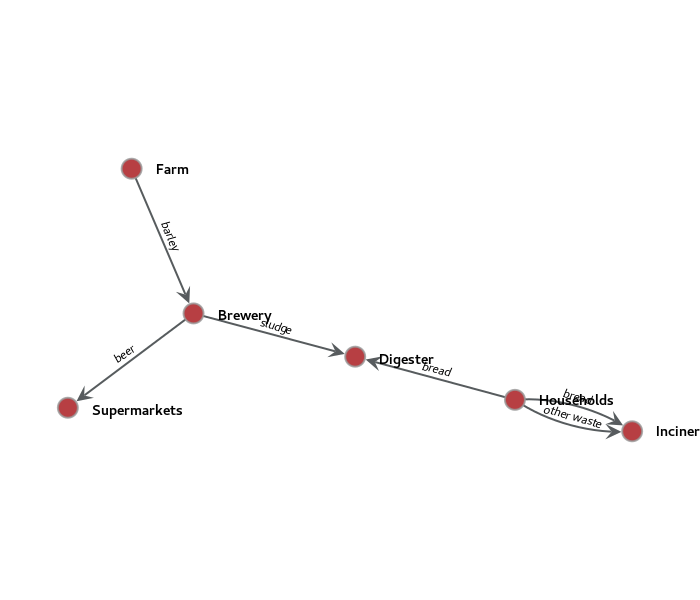

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f65babe2860, at 0x7f65bac48668>

In [7]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC},
                   edge_text=eprop_material,
                   output_size=(700,600), inline=True)

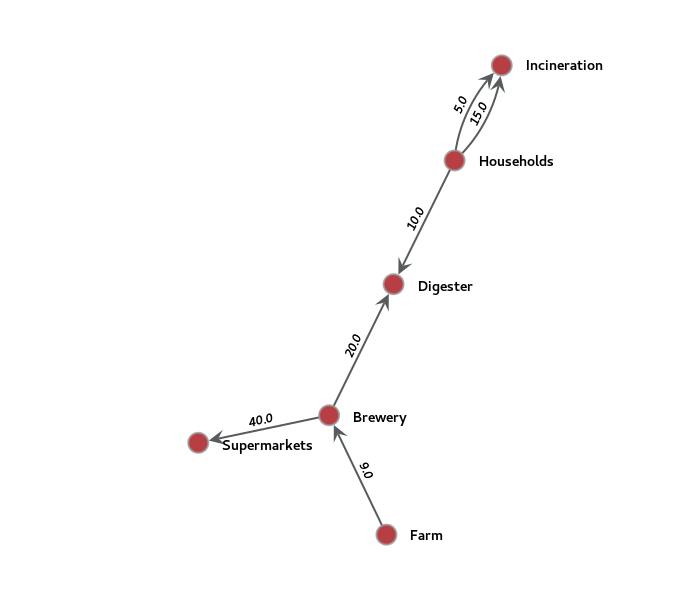

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f65babe2860, at 0x7f65bac48748>

In [8]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text":eprop_mass_text, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True)

In [9]:
def extend_graph(G, mass, material):
    """Add a new node and flow for each node where inflow != outflow to obtain a local mass balance
    
    Returns a modified copy of the graph and edge properties
    """
    g = G.copy()
    eprop_mass = mass.copy()
    eprop_material = material.copy()
    for i, v in enumerate(g.vertices()):
        all_in = v.in_edges()
        all_out = v.out_edges()
        inflow = sum([eprop_mass[ein] for ein in all_in])
        outflow = sum([eprop_mass[out] for out in all_out])
                
        if inflow == outflow:
            break
        elif inflow < outflow:
            diff = outflow - inflow
            nv = g.add_vertex(1)
            ne = g.add_edge(nv, v)
        elif inflow > outflow:
            diff = inflow - outflow
            nv = g.add_vertex(1)
            ne = g.add_edge(v, nv)
        else:
            print('Something went terribly wrong')
            
        g.vp.id[nv] = '_temp'
        eprop_mass[ne] = diff
        eprop_material[ne] = '_temp'
        
    return (g, eprop_mass, eprop_material)

In [10]:
g_new, emass_new, emat_new = extend_graph(g_split, eprop_mass, eprop_material)

In [12]:
gt.draw.graph_draw(g_new, vertex_size=20, vertex_text=g_new.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC},
                   edge_text=emat_new,
                   output_size=(700,600), inline=True)

ValueError: Received property map for graph <Graph object, directed, with 12 vertices and 12 edges at 0x7f65babe78d0> (base: <Graph object, directed, with 12 vertices and 12 edges at 0x7f65babe78d0>), expected: <Graph object, directed, with 6 vertices and 6 edges at 0x7f65babe2860> (base: <Graph object, directed, with 6 vertices and 6 edges at 0x7f65babe2860>)

## Solution – Bread to Beer

The solution shifts the bread waste from Households-Incineration to Households-Brewery, because the bread waste will be used to produce beer. That means that 27t of bread waste is shifted to Brewery, so a new flow is created, and one is removed.

In [ ]:
pe = g_split.edge(g_split.vertex(0), g_split.vertex(1), all_edges=True)
sol_e_remove = [e for e in pe if eprop_material[e] == 'bread'][0] # the specific edge (blue)

In [ ]:
# add the flow Households-->Brewery
sol_e_add = g_split.add_edge(g_split.vertex(0), g_split.vertex(3))
eprop_material[sol_e_add] = eprop_material[sol_e_remove]
eprop_mass[sol_e_add] = eprop_mass[sol_e_remove]
eprop_mass_text[sol_e_add] = eprop_mass[sol_e_remove]

g_split.remove_edge(sol_e_remove)

Also, the solution defines that the Brewery can convert 500kg of bread to 4000 liters of beer. In the GDSE we deal with tons only as units, thus for now we convert this amounts to 0.5t bread to 4t beer. Thus the conversion factor is 8.

In [ ]:
vtx_conversion = g_split.new_vertex_property("object")

In [ ]:
vtx_conversion[g_split.vertex(3)] = [ {'from':'bread', 'to':'beer', 'ratio': 8}, {'from':'bread', 'to':'sludge', 'ratio': 0.5} ]

In [ ]:
for v in g_split.vertices():
    if vtx_conversion[v]:
        print(vtx_conversion[v])

In [ ]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text":eprop_mass_text, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True)

In [ ]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text":eprop_material, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True)